<a href="https://colab.research.google.com/github/chrisjmccormick/llm-tuning-examples/blob/main/stack_llama_2/HuggingFace_StackLLaMA_Finetuning_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ▂▂▂▂▂▂▂▂▂▂▂▂▂▂

# Introduction

## I.1. The StackLLaMa Example

HuggingFace produced this example project to demonstrate their `trl` library (Transformer Reinforcement Learning).

Using the Stack Exchange dataset (which provides roughly 30M examples of question and answer pairs), they demonstrate how to take a "raw" language model and take it through the same Supervised Fine-Tuning (SFT) + Reinforcement Learning (RL) training methodology that was used to turn GPT-3.5 into the much better-behaved ChatGPT.

I believe the intent here is to train the model to be better at answering questions. 🤷‍♂️ There's more on the task itself down in the Dataset section of the Notebook.

Their example is divided into two parts, one for the SFT step and the other for the RL step. Since my primary question here is "is this doable on a single GPU?", I wanted to start with just step 1 for now--the fine-tuning step.


## I.2. Mistral-7B

They used LLaMa from Facebook as their raw LLM starting point, and then dubbed the final trained model "StackLLaMa".

The more recent Mistral 7B model claims superiority, seems to be very popular and, most importantly... doesn't require filling out a form to get access to the weights. 😅

So I've swapped in Mistral 7B instead, and now I suppose we're building "StackMistral"!

Here's a timeline of these different models and some relevant links for reference:

* Feb 2023 - LLaMa 1
* Jul 2023 - LLaMa 2
* Sep 2023 - Mistral 7B ([post](https://mistral.ai/news/announcing-mistral-7b/), [model card](https://huggingface.co/mistralai/Mistral-7B-v0.1))






## I.3. StackLLaMa v1 and v2



They've published two versions of this example, and I'm going off of version 2 in this tutorial.

The original author is Leandro Von Wera (who appears to be the maintainer of the `trl` library?).


**Version 1**

The [blog post](https://huggingface.co/blog/stackllama), published 4/5/23.



The code (in script form) for the example is on GitHub under [examples/ research_projects/ stack_llama/ scripts/](https://github.com/huggingface/trl/tree/main/examples/research_projects/stack_llama/scripts/)

The dataset they used in both examples is `stack-exchange-paired`, which you can view on huggingface datasets [here](https://huggingface.co/datasets/lvwerra/stack-exchange-paired).



**Version 2**

They released a second version built on LLaMa 2, and demonstrated using the "DPO" method for the reinforcement learning part.

They also tweaked a few other training settings for the SFT step, and we'll use those updated settings here.

Their [blog post](https://huggingface.co/blog/dpo-trl), published 8/8/23.

The code (in script form) is available on their GitHub under [examples/ research_projects/ stack_llama_2/ scripts/](https://github.com/huggingface/trl/tree/main/examples/research_projects/stack_llama_2/scripts)



**Trained Versions**

In order to get your hands on LLaMa v1 or v2, you have to fill out a form to request it from Facebook 🙁 (which is why we'll be using Mistral-7B instead!).

For StackLLaMa version 1, they didn't exactly publish the fully trained version, just the adapter weights that you can then apply to LLaMa v1.

However, for version 2, they _did_ publish the full trained model (meaning you don't need to first acquire LLaMa 2 to download and try it out!).

There's also a web app embedded in their StackLLaMa 2 [blog post](https://huggingface.co/blog/dpo-trl) that let's you quickly try it out!



**This Notebook**

This Notebook is a (heavily modified 😝) version of the fine-tuning script, [supervised_finetuning.py](https://github.com/huggingface/trl/blob/main/examples/research_projects/stack_llama/scripts/supervised_finetuning.py).








**Parameter Choices**

| Settings                    | Version 1       | Version 2       |
|-----------------------------|-----------------|-----------------|
| Model                       | LLaMA 1 7B      | LLaMA 2 7B      |
| Maximum Sequence Length     | 1024            | None            |
| Effective Batch Size        | 4               | 8               |
| Batch Size, Accumulation Steps | 4, 1         | 4, 2            |
| Learning Rate               | 1e-5            | 1e-4            |
| Steps                       | 5000            | 500             |
| Optimizer                   | -               | paged_adamw_32bit |
| Gradient Checkpointing      | False           | False           |
| Lora ‘r’ and ‘alpha’        | r=16, alpha=32  | r=8, alpha=16   |
| Quantization                | 8-bit           | 4-bit           |
| BFloat16                    | False           | True            |

A couple parameter choices aren't specified, and so must be using the default values. The documentation is hard to follow, but as best I can tell the default optimizer for the Trainer is AdamW, and setting the sequence length to 'None' causes it to retrieve that value from the tokenizer.


## I.4. GPU Selection

You'll want to use different settings to run this Notebook on the **T4** (free) vs. the **L4** or **A100** (paid).

(FYI, I went into depth on the available Colab GPUs and their features and pricing [here](https://mccormickml.com/2024/04/23/colab-gpus-features-and-pricing/)).

Here are the ideal settings that will work for each GPU. This Notebook is currently configured with the settings required to run on the **T4**.

|  GPU | dtype | Seq Len | Grad Check | Batch Size | Accumulation Steps | Memory Use |   Time   | Speed vs. T4 |
|:----:|:----:|:-------:|:----------:|:----------:|:------------------:|:----------:|:------------------------------:|:------------:|
|  **T4**  |   float16  |  1024  |    True    |      1     |          4         | 7.0GB      | ~2h 10min |      1x      |
|  **L4**  |   bfloat16  |   1024  |    False   |      1     |          4         |  17.5GB    | ~47min      |     2.8x     |
| **A100** |   bfloat16  |   1024  |    False   |      2     |          2         |   28.1 GB  | ~10min |      13x     |

The last three columns (memory use, training time, and the speed comparison vs. the T4) are just for reference, but the other columns indicate specific settings to use.

Note: One hack to get around a lot of the memory and performance issues would be to simply use a much smaller model. I've seen Facebook's `OPT-350m` used in some of HuggingFace's other examples.
    * https://huggingface.co/facebook/opt-350m
    * ~125k downloads last month
    * Published 5/2/22 - 6/21/22

**TODO**

* In reporting the above times, I forgot about the validation step--it adds a lot to the total training time!
* The examples validation set size of 4,000 isn't practical on the T4... I've reduced it to _50_ for now.
* The v2 example actually uses an effective batch size of 8, so I need to up the accumulation steps!
    * This may be **critical**, since the learning rate was tuned for that batch size.
* I'll need to make it clear how users can change these settings in the notebook.








# ▂▂▂▂▂▂▂▂▂▂▂▂▂▂

# Fine-Tuning Code

On to the example code!



**NOTE! API Keys Required**

This Notebook currently requires both a huggingface API key (necessary for accessing mistral 7B) and wandb API key (optional--you could disable wandb in the training arguments). I made use of the 'secrets' panel in Colab to do this. You can do the same, or just paste your key directly into the code (in your own private copy of the Notebook).

**TODO** - Provide some direction on how to do this!

# S1. Setup

## 1.1. Install Packages

There are quite a number of packages related to getting LLMs to fit and be trainable on a single GPU!

In [85]:
import time

# Track the total time to run all of the package installations.
t0 = time.time()

Install FlashAttention.

In [86]:
!pip install -U flash-attn

In [87]:
!pip install accelerate

Upgrading pyarrow is a workaround for an error I was getting when trying to run `load_datasets`. It was the same error as reported [here](https://github.com/mgeraeds/hires-processing/issues/3).

In [88]:
!pip install --upgrade pyarrow

In [89]:
!pip install bitsandbytes

I saw this installation in documentation [here](https://huggingface.co/docs/trl/lora_tuning_peft), but it may not be necessary?

In [90]:
!pip install loralib

In [91]:
!pip install wandb

In [92]:
!pip install datasets

In [93]:
!pip install peft

In [94]:
!pip install trl

Import these two packages to make sure I'm not encountering that error still.

In [95]:
import pyarrow

In [96]:
import pandas

## 1.2. HuggingFace Login

Mistral now requires you to log in to HuggingFace to download their model (and to accept their agreement [here](https://huggingface.co/mistralai/Mistral-7B-v0.1))

TODO - Explain how to set this up.

In [97]:
from google.colab import userdata

# I used the "secrets" panel in Colab and defined the variable
# "hf_hub_all_notebooks" and set it to my personal huggingface key.
# You could just paste in your key directly here if this is a private copy.
hf_api_key = userdata.get('hf_hub_all_notebooks')

!huggingface-cli login --token $hf_api_key

Token has not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /root/.cache/huggingface/token
Login successful


## 1.2. Helper Functions

In [98]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


I've got a helper function for allowing us to check out the memory usage of the model.

In [99]:
import os
import pandas as pd
import csv

def check_gpu_mem():
    '''
    Uses Nvidia's SMI tool to check the current GPU memory usage.
    '''

    # Run the command line tool and get the results.
    buf = os.popen('nvidia-smi --query-gpu=memory.total,memory.used --format=csv')

    # Use csv module to read and parse the result.
    reader = csv.reader(buf, delimiter=',')

    # Use a pandas table just for nice formatting.
    df = pd.DataFrame(reader)

    # Use the first row as the column headers.
    new_header = df.iloc[0] #grab the first row for the header
    df = df[1:] #take the data less the header row
    df.columns = new_header #set the header row as the df header

    # Display the formatted table.
    #display(df)

    return df

This helper function prints out big numbers nicely using base 2 magnitudes (i.e., K = 2^10, M = 2^20, B = 2^30)

In [100]:
def format_size(num):
    """
    This function iterates through a list of suffixes ('K', 'M', 'B') and
    divides the input number by 1024 until the absolute value of the number is
    less than 1024. Then, it formats the number with the appropriate suffix and
    returns the result. If the number is larger than "B", it uses 'T'.
    """
    suffixes = ['', 'K', 'M', 'B']
    base = 1024

    for suffix in suffixes:
        if abs(num) < base:
            if num % 1 != 0:
                return f"{num:.2f}{suffix}"

            else:
                return f"{num:.0f}{suffix}"

        num /= base

    # Use "T" for anything larger.
    if num % 1 != 0:
        return f"{num:.2f}T"

    else:
        return f"{num:.0f}T"



In [101]:
print("All of that package installation stuff took:", format_time(time.time() - t0))

All of that package installation stuff took: 0:00:59


According to the HuggingFace docs [here](https://huggingface.co/docs/transformers/v4.39.3/en/main_classes/model#transformers.PreTrainedModel.from_pretrained.attn_implementation):

> "if available, SDPA will be used for torch>=2.1.1. The default is otherwise the manual "eager" implementation."

(Or check the latest documentation [here](https://huggingface.co/docs/transformers/main/en/main_classes/model#transformers.PreTrainedModel.from_pretrained.attn_implementation)).

In [102]:
import torch
print(torch.__version__)

2.2.1+cu121


# S2. Dataset

HuggingFace has a huge StackExchange dataset called `stack-exchange-preferences`, [here](https://huggingface.co/datasets/HuggingFaceH4/stack-exchange-preferences/), and this Notebook uses a variant of it called `stack-exchange-paired`, [here](https://huggingface.co/datasets/lvwerra/stack-exchange-paired).

In the original dataset, each sample consists of a question plus multiple user answers.

For the "paired" version, the samples consist instead of a question and only two user answers, labeled "j" and "k", where answer "j" is the preferred one.


The dataset pages are a nice way to view some statistics and examples.

For [stack-exchange-paired](https://huggingface.co/datasets/lvwerra/stack-exchange-paired):
* It consists of 26.8M training samples and 4.48M test samples.
* It's 26.3GB if you were to download it!

They sampled "at most 10 pairs per question", which means you will see the **same question repeated** multiple times in the dataset, just with different response pairs.

The Notebook used to create the 'paired' version of the dataset is [here](https://colab.research.google.com/#fileId=https%3A//huggingface.co/datasets/lvwerra/stack-exchange-paired/blob/main/StackExchangeProcessing.ipynb).

The original `stack-exchange-preferences` dataset shows the full list of "exchanges" (topics) included in the dataset, [here](https://huggingface.co/datasets/HuggingFaceH4/stack-exchange-preferences/blob/main/stack_exchanges.json). There are 343 in total, but I imagine the distribution is heavily skewed (towards, e.g., programming)?

## 2.1. Stream Dataset

Define arguments...

In [103]:
import argparse

# Instantiate an empty Namespace object
args = argparse.Namespace()

# Define and set default values for attributes



I'm using mistral-7b instead of LLaMa.

Even though we're not loading the model till later on, we need to set this now in order to load the appropriate tokenizer.

In [104]:
args.model_path = "mistralai/Mistral-7B-v0.1"

For this notebook, we're using the "finetune" portion of the dataset--though I don't know what the other subsets are?

In [105]:
# Dataset arguments
args.dataset_name = "lvwerra/stack-exchange-paired"
args.subset = "data/finetune"

Presumably there are train and test splits?

In [106]:
args.split = "train"

We'll be streaming the dataset. This is cool feature--rather than downloading the dataset in advance, we'll be pulling samples and processing them as we go. This eliminates a long pre-processing step, and doesn't appear to impact training speed. (I mean, think about the difference in complexity of manipulating some text vs. running a 7B parameter model!)

In [107]:
args.streaming = True

# Related to streaming the dataset.
args.shuffle_buffer = 5000

In [108]:
# This is used during the dataset setup as part of the shuffling step...
args.seed = 0

Load dataset... What does this do given that we're streaming?

In [109]:
from datasets import load_dataset

# Original call:
#    train_dataset, eval_dataset = create_datasets(tokenizer, args)

# This is a function from teh huggingface datasets library.
dataset = load_dataset(
    args.dataset_name, # "lvwerra/stack-exchange-paired"
    data_dir = args.subset, # "data/finetune"
    split = args.split, # "train"

    #use_auth_token = True,

    # We're streaming, so this is unnecessary.
    #num_proc = args.num_workers if not args.streaming else None,

    streaming = args.streaming, # "True"
)



Resolving data files:   0%|          | 0/20 [00:00<?, ?it/s]

In [110]:
print(type(dataset))

<class 'datasets.iterable_dataset.IterableDataset'>


Training and Validation sets.

TODO - What's going on in these two blocks?

In [111]:
# The version 2 example has the validation set size at 4,000, which would take
# a very long time on the T4--Much longer than the 500 training steps!
# We're going to take 4,000 of the training samples out to use as our validation
# set (for evaluating the model's performance mid-training).
#args.size_valid_set = 4000
args.size_valid_set = 50

# We're streaming the dataset...
if args.streaming:
    print("Loading the dataset in streaming mode")
    valid_data = dataset.take(args.size_valid_set)
    train_data = dataset.skip(args.size_valid_set)
    train_data = train_data.shuffle(buffer_size=args.shuffle_buffer, seed=args.seed)

# (Unused)
else:
    dataset = dataset.train_test_split(test_size=0.005, seed=args.seed)
    train_data = dataset["train"]
    valid_data = dataset["test"]
    print(f"Size of the train set: {len(train_data)}. Size of the validation set: {len(valid_data)}")


Loading the dataset in streaming mode


## 2.2. Inspect An Example

Let's print out an example from the dataset (I dug through the dataset a bit to find an interesting one).

In [112]:
# Which example do we want to look at?
example_i = 3172

# Loop through the training examples to reach our desired index.
# Note that this does actually retrieve the examples, so it's probably best not
# to try and access one far in!
for (i, example) in enumerate(dataset):

    # Skip them until we reach the desired one.
    if i == example_i:
        print(example)

        # Exit the loop.
        break

# Store this specific example to be used later when we check out the model's
# performance prior to tuning.
plucked_example = example

{'qid': 8252, 'question': 'This question is only regarding aircraft that seat more than about 100 people. \n\nAre cargo holds pressurised these days, what is the situation?\n\nAre only some pressurized, most, of every single one? Does it depend on the carrier, operating region or are there other variations that matter?\n\nRelated questions:\n\n* Are cargo holds heated?\n* Do they have lights? (Aren\'t some lit for animals?)\n* I\'ve noticed random mentions of "some" of the sections being pressurised. Is this correct? It would seem to me that, if indeed, only **some** are pressurised then, of course, you absolutely could not **rely** on your luggage being in a pressurised area.\n* and what about Fedex-type cargo-only aircraft?\n\nTo be clear, I ask this question re "today" because I noticed when googling on this, there is a lot of information, but only old information (say, 10 yrs old plus). That is a recipe for confusion and urban myth, so the total facts from you experts would be grea

The example is stored as a dictionary, and the questions and responses are tricky to display nicely.

We'll use `pandas` first to print a compact view of the example.

In [113]:
import pandas as pd

# Create a dataframe from all of the key-value pairs in the dictionary.
df = pd.DataFrame(list(example.items()), columns=["Key", "Value"])

# Use Colab / Jupyter's table rendering.
display(df)


,Key,Value
0,qid,8252
1,question,This question is only regarding aircraft that ...
2,date,2014/08/20
3,metadata,[https://aviation.stackexchange.com/questions/...
4,response_j,Aircraft design has not changed **that** much ...
5,response_k,"Yes, they are pressurized and climate controll..."


To print out the full strings nicely, we can try using the `tabulate` library to format them into an ASCII table.

In [114]:
!pip install tabulate

In [115]:
from tabulate import tabulate

# The table will have two columns, for the keys and values.
headers = ["Key", "Value"]

# Add each key-value pair in the dictionary.
rows = [[key, value] for key, value in example.items()]

table_str = tabulate(rows,
                     headers = headers,
                     tablefmt = "grid")

print(table_str)

+------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Key        | Value                                                                                                                                                                                                                                                                                                                           

For each training sample, we combine the question and the answer (specifically, 'response_j') into a single string with some added formatting.

If the question is "What color is the sky?" and the answer is "The sky is blue.", then this will be formatted as:

```
Question: What color is the sky?

Answer: The sky is blue.
```

I thought it was interesting to see that they insert the blank line in between, implying that these models would find that little bit of whitespace meaningful (in the same way we would).

In [116]:
def prepare_sample_text(example):
    """Prepare the text from a sample of the dataset."""

    # Label the question and the answer, and add a blank line in between. For
    # example:
    #
    # Question: What color is the sky?
    #
    # Answer: The sky is blue.
    text = f"Question: {example['question']}\n\nAnswer: {example['response_j']}"

    return text

We can demonstrate the formatting with a small example.

In [117]:
ex = {}

ex['question'] = "What color is the sky?"
ex['response_j'] = "The sky is blue."

prepare_sample_text(ex)

'Question: What color is the sky?\n\nAnswer: The sky is blue.'

## 2.3. Sample Length Distribution

The authors of the example chose a maximum sequence length of 1024. I'm curious to see how this corresponds to the actual lengths of the examples, so let's plot the distribution of lengths.

To get the lengths, we'll need to tokenize the examples.

In [118]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(args.model_path)


**TODO** - There are a couple of lines here that seem like they could be rather critical, but I'm not sure why or what they're really about.

These did not appear in version 1 of the StackLLaMA example, but are in version 2.

Also, because I'm running with Mistral 7B instead of LLaMA 2, it's possible that these changes don't apply, or that different changes should be made! 😳

In [119]:
print(tokenizer.pad_token)
print(tokenizer.eos_token)

tokenizer.pad_token = tokenizer.eos_token

None
</s>


In [120]:
print(tokenizer.padding_side)

tokenizer.padding_side = "right"  # Fix weird overflow issue with fp16 training

left


What Tokenizer is being used?
(I don't have any interesting insights from this)

In [121]:
print(tokenizer)

LlamaTokenizerFast(name_or_path='mistralai/Mistral-7B-v0.1', vocab_size=32000, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '</s>'}, clean_up_tokenization_spaces=False),  added_tokens_decoder={
	0: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}


I have a number of questions surrounding sequence length at this point:

* How important is it for the example to fit within a single context window?
* How do the various new tricks around expanded context windows impact this parameter, and what's their impact during training vs. inference?


In [122]:
# The model will be given examples of this length.
# This parameter has a big impact on training speed and memory consumption
# because of the attention calculations--we calculate attention between every
# token and every other token (though for GPT we discard half of these values).
# This means there are (sequence length)^2 attention scores calculated at
# each of the model's 32 layers, and we have to store these for training.

args.seq_length = 1024

#args.seq_length = 512

To plot the sample length distribution, let's tokenize a small subset of the dataset and tally up the sample lengths.

> Note: In the next section on "example packing", we're going to need to have an estimate of the average number of characters per token in the dataset, so we'll gather that statistic here as well.

In [123]:
from tqdm import tqdm

print('Gathering sample length statistics...')

# We'll gather statistics from a subset of the dataset.
nb_examples = 3000

# We'll store the token lengths of the samples so that we can plot a
# histogram to check out their distribution.
token_lengths = []

# We're also going to calculate the average number of characters per token
# because this is needed later for "example packing".
total_characters = 0
total_tokens = 0

# For each of the examples... (use tqdm to render a progress bar)
for _, example in tqdm(zip(range(nb_examples), iter(train_data)),
                       total = nb_examples):

    # Prepare a training sample by combining the question and answer with some
    # formatting.
    text = prepare_sample_text(example)

    # Add the total characters in this sample to the running total.
    total_characters += len(text)

    # Tokenize the example, just to get the number of tokens it turns into.
    # Apparently the syntax for tokenizing is different depending on whether
    # it's a "fast" type tokenizer.
    # (In this example, we are using a "fast" one.)
    if tokenizer.is_fast:
        ex_num_tokens = len(tokenizer(text).tokens())
    else:
        ex_num_tokens = len(tokenizer.tokenize(text))

    # Add the number to the running total.
    total_tokens += ex_num_tokens

    # Add the number to the list so we can later plot the distribution.
    token_lengths.append(ex_num_tokens)

print('\nDone.')

Gathering sample length statistics...


100%|██████████| 3000/3000 [00:07<00:00, 400.19it/s]


Done.


Let's grab some quick statistics--what are the min, max and median comment lengths from this subset?

In [124]:
import numpy as np

print('   Min length: {:,} tokens'.format(min(token_lengths)))
print('   Max length: {:,} tokens'.format(max(token_lengths)))
print('Median length: {:,} tokens'.format(int(np.median(token_lengths))))

   Min length: 46 tokens
   Max length: 8,186 tokens
Median length: 441 tokens


To further analyze it, let's plot the distribution.


Text(0, 0.5, '# of Samples')

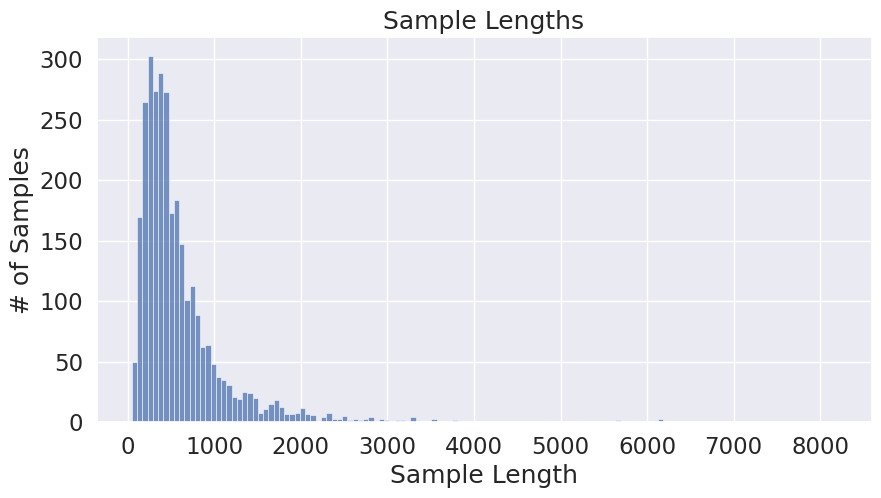

In [125]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (10,5)

# Plot the distribution of comment lengths.
sns.histplot(token_lengths)

plt.title('Sample Lengths')
plt.xlabel('Sample Length')
plt.ylabel('# of Samples')


Looking at this plot, it seems like 1,024 is a reasonable choice near the "elbow" of the curve.

More concretely, how many samples are going to be cut short?



In [126]:
print('For a maximum sequence length of {:,}...'.format(args.seq_length))

# How many of the examples are longer than X tokens?
num_truncated = np.sum(np.asarray(token_lengths) > args.seq_length)

# Sanity check
assert(len(token_lengths) == nb_examples)

# Calculate the percentage that are truncated.
prcnt = float(num_truncated) / float(nb_examples)

print('{:,} of {:,} examples ({:.1%}) will be truncated.'.format(num_truncated, nb_examples, prcnt))

For a maximum sequence length of 1,024...
393 of 3,000 examples (13.1%) will be truncated.


## 2.4. Example Packing

Example packing is "where multiple short examples are packed in the same input sequence to increase training efficiency. This is done with the ConstantLengthDataset utility class that returns constant length chunks of tokens from a stream of examples." (from [here](https://huggingface.co/docs/trl/en/sft_trainer)).

In the previous section, we tallied up the total characters and total tokens from a subset of the dataset, and we'll use this to estimate the average number of characters per token.

The `ConstantLengthDataset` uses this estimate in some way--perhaps as a way to make an initial guess at the token count for a sample, to decide whether to try packing particular samples together?

In [127]:
# Estimate the average number of characters per token (for example packing)
chars_per_token = total_characters / total_tokens

print(f"\n\nThe character to token ratio of the dataset is: {chars_per_token:.2f}")



The character to token ratio of the dataset is: 3.22


In [128]:
from trl.trainer import ConstantLengthDataset

train_dataset = ConstantLengthDataset(

    # Pass in the original dataset, and the tokenizer.
    tokenizer,
    train_data,

    # The dataset hasn't been formatted into "Question: --- Answer: ---" yet;
    # we give this a handle to our function to do it for us.
    formatting_func = prepare_sample_text,

    infinite = True, # TODO - Probably that we're not just going to do a single
                     #        pass over the dataset, so it's ok to re-use
                     #        samples.

    # We have to provide a sequence length we want to use!
    seq_length = args.seq_length,

    # The utility class wants to know this dataset statistic. It must use it
    # to help make some initial decisions.
    chars_per_token = chars_per_token
)

# Do the same thing for the validation dataset. Infinite is false, though.
valid_dataset = ConstantLengthDataset(
    tokenizer,
    valid_data,
    formatting_func=prepare_sample_text,
    infinite=False,
    seq_length=args.seq_length,
    chars_per_token=chars_per_token,
)


In [129]:
# TODO - This was in the original example, and I'm not clear on the purpose.
train_dataset.start_iteration = 0

# S3. Load & Inspect Model

Let's see how much GPU memory we have, and how much is used prior to loading the model. (`check_gpu_mem` was defined up in section 1.2.)

In [130]:
# Check out memory useage prior to loading.
check_gpu_mem()

,memory.total [MiB],memory.used [MiB]
1,15360 MiB,5741 MiB


## 3.1. 4-bit Quantization

**How it Works**

Unlike reducing precision (e.g., going from 32-bit parameters down to 16-bit), 4-bit quantization is more like a **compression** technique, where the stored values **aren't useable** until they're decompressed again.

(Simply rounding down to 4-bits would be insane--that's only 16 unique values!)

The weight values are broken down into a **4-bit base value** multiplied by a **16-bit scaling factor**.

...but that uses _more_ memory than before (20-bits per value), not less! 🤨

In order to actually compress the data, every **64 values** in the weights will all share a single 16-bit scaling factor.

(The number 64 is called the "block size", and seems to be hardcoded into the algorithm).

If you do the math--64 values that originally required 128 bytes to store now require 34 bytes in compressed form. A compression ratio of **3.76x**.

In order for the weights to actually be useable in calculations, we have to **decompress** them by multiplying the 4-bit values with their corresponding scaling factor to get back (roughly?) the original values at 16-bit precision.

I have a more in-depth tutorial on quantization here - **TODO**


**Running Quantization**

When we call `from_pretrained`, it's going to download the full-sized model from huggingface (according to the progress bar it's about 14.5GB), and then run this compression algorithm on the weights before loading the model onto the GPU.

An interesting consequence of applying quantization is that it's not possible to make updates to quantized weights! We'd have to re-run compression after every training step.

This means we have to freeze those parameters, and use LoRA in order to actually fine-tune the model. This adds additional weights for us to tune instead.

(Note: Quantization doesn't get applied to the layer normalization weights, the input embeddings, or the final language model output head.)

**StackLLaMA 1 vs. 2**

Version 1 used 8-bit quantization [here](https://github.com/huggingface/trl/blob/57aebe9c36021e679662181468b04ff42432daf3/examples/research_projects/stack_llama/scripts/supervised_finetuning.py#L172), but version 2 used 4-bit quantization [here](https://github.com/huggingface/trl/blob/57aebe9c36021e679662181468b04ff42432daf3/examples/research_projects/stack_llama_2/scripts/sft_llama2.py#L149).

They did not use double quantization--I think this technique may only save a modest amount of memory, presumably slows the model down, and I'm not sure what impact it has on model quality.

Here is the configuration object for setting up 4-bit quantization.

In [131]:
import torch
from transformers import BitsAndBytesConfig

bnb_config = BitsAndBytesConfig(
    # Enable 4-bit quantization.
    load_in_4bit = True,

    # With "double quantization" we not only compress the weights, we compress
    # the scaling factors as well!
    bnb_4bit_use_double_quant = False,

    # The authors did some analysis of the distribution of weight values in
    # popular transformer models, and chose some hardcoded values to use as the
    # 16 "base values", which seem to better allocate the available precision.
    # You can use these hardcoded values by choosing "nf4".
    #
    # The alternative choice is "float4", which presumably just uniformly
    # distributes the 16 base values.
    bnb_4bit_quant_type = "nf4",

    # Pretty sure this is the precision of the scaling factors.
    # It may be that the key choice here is 'float16' vs. 'bfloat16' -- I'm
    # sure we want it to match what's used for the model and for LoRA.
    # If T4:
    bnb_4bit_compute_dtype = torch.float16
    #bnb_4bit_compute_dtype = torch.bfloat16

    # Note that the "block size" of 64, which determines the compression ratio,
    # doesn't appear to be configurable!
)

## 3.2. Download Model

This will:

* Download the model (about 14.5GB)
* Compress it, following the quantization configuration
* Load it onto the GPU.

In [132]:
#from transformers import AutoModelForCausalLM
from transformers import MistralForCausalLM

t0 = time.time()

#model = AutoModelForCausalLM.from_pretrained(

model = MistralForCausalLM.from_pretrained(

    args.model_path, # "mistralai/Mistral-7B-v0.1"

    # Our 4-bit quantization setup defined in the previous section.
    quantization_config = bnb_config,

    # Currently, you can't use this unless you're running an A100 or L4.
    #attn_implementation = "flash_attention_2",

    attn_implementation = "sdpa",
    #attn_implementation = "eager",

    # I assume it's critical that this datatype match the one used in
    # the quantization configuration, and in LoRA!
    #torch_dtype = torch.bfloat16,
    # If T4:
    torch_dtype = torch.float16,

    # I was getting this output message:
    #    "`low_cpu_mem_usage` was None, now set to True since model is
    #      quantized."
    # So I'm setting it to "True" as the message suggests. :)
    #
    # I tried setting it to False out of curiousity, and it crashed with:
    #    "Your session crashed after using all available RAM."
    low_cpu_mem_usage = True,

)

print("\nDownloading / loading model took", format_time(time.time() - t0))


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Not sure what this does (this comes from the huggingface code).

In [133]:
model.config.use_cache = False

I'm always curious what the actual class name is... 😊

In [134]:
print(type(model))

<class 'transformers.models.mistral.modeling_mistral.MistralForCausalLM'>


It'd be interesting to grab, for comparison, the memory consumption for 4-bit quantization vs. 8-bit, and how much is saved by further compressing the scaling factors using "double quantization".

Also, I noticed that the memory consumption is actually different between the T4 and A100, presumably because they support some different CUDA features.

In [135]:
# And now memory usage after loading.
check_gpu_mem()

,memory.total [MiB],memory.used [MiB]
1,15360 MiB,10443 MiB


Printing out the model architecture can be informative...

I thought it was interesting to see:

* 32 layers
* 4,096 embedding size
* The weight matrices are replaced with quantized versions named Linear4bit

In [136]:
model

MistralForCausalLM(
  (model): MistralModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x MistralDecoderLayer(
        (self_attn): MistralSdpaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): MistralRotaryEmbedding()
        )
        (mlp): MistralMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): MistralRMSNorm()
        (post_attention_layernorm): MistralRMSNorm()
      )
    )

# S4. Performance Before Tuning

**TODO** - Pick some interesting examples to evaluate the model on, and add some reflections about it.

In [137]:
# Earlier in the Notebook, we selected a specific example to look at and play
# with.
example = plucked_example

text = f"Question: {example['question']}\n\nAnswer: "

#Desired answer: {example['response_j']}

In [138]:
device = "cuda:0"

# Tokenize the text, which returns it as a list of token ids.
input_ids = tokenizer(
    text,
    return_tensors = "pt" # Return them in a Pytorch Tensor.
)

# Move them to the GPU.
input_ids = input_ids.to(device)


In [139]:
# Feed it in and generate output!

# These settings come from the widget in their blog post (I believe they are
# the defaults they set for the widget?), except I doubled the sequence length.
outputs = model.generate(**input_ids,
                         max_length=1024,

                         do_sample = True,
                         temperature = 0.9,
                         top_p = 0.9,
                         repetition_penalty = 1.2)

# Using defaults instead:
#outputs = model.generate(**input_ids)

In [ ]:
# Decode the input + output tokens back into readable text.
full_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

Print it all out, wrap to 80 characters wide.

**TODO** - Address linebreak issues following advice [here](https://stackoverflow.com/questions/1166317/python-textwrap-library-how-to-preserve-line-breaks).

In [147]:
import textwrap

# Wrap text to 80 characters.
wrapper = textwrap.TextWrapper(
    width = 80,
    break_long_words = False,
    replace_whitespace = False
)


print(wrapper.fill(full_text))

Question: This question is only regarding aircraft that seat more than about 100
people. 

Are cargo holds pressurised these days, what is the situation?

Are
only some pressurized, most, of every single one? Does it depend on the carrier,
operating region or are there other variations that matter?

Related questions:
* Are cargo holds heated?
* Do they have lights? (Aren't some lit for animals?)
* I've noticed random mentions of "some" of the sections being pressurised. Is
this correct? It would seem to me that, if indeed, only **some** are pressurised
then, of course, you absolutely could not **rely** on your luggage being in a
pressurised area.
* and what about Fedex-type cargo-only aircraft?

To be clear,
I ask this question re "today" because I noticed when googling on this, there is
a lot of information, but only old information (say, 10 yrs old plus). That is a
recipe for confusion and urban myth, so the total facts from you experts would
be great.

(Possibly, it would be diffic

For comparison, here is [what ChatGPT has to say](https://chat.openai.com/share/fa3973db-0d1f-4538-b639-8c630f4da658) about pressurized cargo holds (short answer--yes, they're pressurized).

# S5. Training with Low Memory

4-bit quantization gets the model to fit in memory, but there are a handful of other tricks we're going to need to employ in order to be able to fit the fine-tuning process in memory.

I'll go over them here before we apply them down in the "Training Arguments" part of the code.

**TODO** - I plan to move the LoRA and Paged Optimizers sections into their own separate tutorials, and provide much more condensed explanations in this Notebook!

## 5.1. LoRA

LoRA stands for Low Rank Adaptation. It's a particular Parameter Efficient Fine-Tuning ("peft") technique, but it seems to be so much the default choice that maybe we don't even need a category for "peft" approaches anymore. 😅



**Learning Without Forgetting**

The goal of fine-tuning is to modify the LLM's behavior in some way, without losing all of the incredible capabilities of the original model.

> Note: I could imagine why it might be challenging to retain the original capabilities. If you try to fine-tune the LLM to predict the next word in a small dataset, why should it bother with language understanding when it could probably just memorize the contents of your dataset?! 😝

One way to achieve this is to not touch the original model at all (i.e., "freeze" the original weights), and instead train some additional small components that we add to the model in order to "adjust" it's behavior.



**Adapter Layers vs. LoRA**

"Adapter Layers" were were an approach to this where we inserted additional (presumably small?) feed-forward neural networks into the model's flow.



![Adapter Layers Illustration](https://miro.medium.com/v2/resize:fit:4800/format:webp/1*_uWLznsq8ClxcCA57HDlXA.png)

LoRA, on the other hand, seems a little more logical to me. Instead of _inserting_ neural networks, we add them to the side.

An embedding goes through the original model component, as well as a small calculation on the side, and the result of the small calculation is added onto the result of the original component. This parallel flow is captured by the below illustration (ignore the _equations_ given for `A` and `B`--these state how those two matrices are initialized, which doesn't seem worth emphasizing!).

![LoRA's parallel calculation illustration](https://miro.medium.com/v2/resize:fit:1086/format:webp/1*x7xuaEJGVKvaF_F_XOtwJA.png)

This illustration comes from the original LoRA paper [here](https://arxiv.org/pdf/2106.09685) (First authors are Edward Hu and Yelong Shen at Microsoft).

In the example in this Notebook the "rank" `r` is set to 16, and we're using Mistral 7B which has an embedding size of 4,096.

Our "side calculation" is to take the embedding $ x $ of $ 1 \times 4096 $ and project it onto a matrix $ A $ of $ 4096 \times 16 $ to get an intermediate vector that is only $ 1 \times 16 $!

Before we can add our "adjustment" back in, we have to project back into the embedding space by multiplying our $ 1 \times 16 $ vector with a $ 16 \times 4096 $ matrix $ B $.



**What's "Low Rank"?**

Rank is a matrix math concept. If we take $ C = AB $, then $ C $ has "rank 16". It's a big matrix that can actually be represented by two much smaller ones.

This concept has important implications in a neural network. Here's the terminology / framing I'd prefer.

Think of A and B as defining a neural network with 16 neurons in the hidden layer. Each of the 16 neurons is looking for a different pattern in the input embedding.

When we take the dot product between the embedding and the weights of one of the neurons, we get a single value that reflects the similarity between the input and the pattern stored by the neuron.

So $ A $ defines our hidden layer of 16 neurons, and is only capable of extracting 16 features from the input embedding (whereas $ W $ extracts 4,096!).

The output of our hidden layer is just $ 1 \times 16 $--16 neuron activations.

Then, $ B $ stores 16 different possible "adjustments" to make to the result of $ xW $. The adjustments in B are scaled by the "activation" of the corresponding neuron.  

For example, if neuron 0 responds strongly to the input embedding (i.e., has a high dot product), then row 0 of $ B $ will be scaled up and have a stronger impact on the result of $ xW $.



**Linear vs. Non-Linear**

One flaw in my "neural network" analogy, though, is that we aren't applying an activation function to $ xA $.

$ xAB $ only creates a linear model that can't be as "sophisticated" in its behavior as a true neural network.

Limiting this to a linear model may relate to minimizing how much we're able to change the model's behavior--I'm not entirely sure!

But it also has another benefit that I'll explain next.

**Merging LoRA Weights**

A nice property of linear operations like the ones here is that they can often be reduced. _Once A and B have been learned_, we can think of them as constants, and we can actually merge them into the model's weight matrices!

Let's say `W` is one of the original models components, like the "Key" projection matrix in the attention block.

If `x` is an embedding, then the original math was just `xW`.

We're modifying this to `xW + xAB`. Matrix algebra works similar to regular algebra in that we can pull out that `x` to have `x(W + AB)`. Since W, A, and B are all "constants" at this point (because we've completed training), we can just perform the multiplcation and sum `W + AB` to get our new values for `W`.

(Note: In order for the above algebra to work, the operation has to occur _before_ any activation function--i.e., `activation(xW + xAB)`, _not_ `activation(xW) + xAB`).

Merging the LoRA weights back into the original model means that we aren't actually performing any additional math at inference time! The original "adapters" technique added in more model components that would slow down inference.

It also says something kind of interesting about how LoRA works--it's not doing anything that couldn't have been accomplished by modifying the original weights directly!

**Impact on Training Requirements**

LoRA reduces the number of trainable parameters dramatically. For example, if W is [4096 x 4096], that's 16M parameters, but if A and B are [4096 x 16] that's only 128K parameters between the two of them--a reduction of 128x!

(The amount of reduction is based on the embedding size and the 'r' value used. The LoRA paper reports a reduction of 10,000x for GPT-3, which had a whopping embedding size of 12,288!)

Wow! That must have an incredible impact on training speed and memory requirements, right? ...No.

As I discussed in section 3, the problem is that for decent batch sizes and sequence lengths, it's the activation values that dominate the memory consumption, and not the optimizer states.  

The LoRA paper touts a 3x reduction in memory consumption, but I don't think you'll see this in practice. Maybe they got this on some of the common transformer benchmarks like GLUE, which only require sequence lengths of 128 - 512 (see Table 10 of their paper).

The QLoRA paper seems to corroborate this on page 3, under "Memory Requirement of Parameter-Efficient Finetuning", where they point out that "most of the memory footprint for LLM finetuning comes from activation gradients and not from the learned LoRA parameters". They point out that it doesn't cost much to apply to LoRA to more of the model components, and find they get much better results when applying LoRA to all of the weight matrices.

_Optimizing `r`_

I think a key take-away for this is that you probably should think of `r` less in terms of "compression" and "efficiency" and more like fine-tuning the number of neurons in your model. There's probably an ideal value that could be bigger or smaller for your application / dataset.

**Reduced Deployment Cost**

The primary benefit touted by the LoRA paper is different than what you'd expect. They emphasize how this approach makes it much quicker, _in a production setting_, to swap in and out models tuned for different tasks.

For example, if task 1 is defined by A_1, B_1 and task 2 is defined by A_2, B_2, then you can switch from task 1 to 2 by subtracting out task 1 `W - A_1B_1` and adding in task 2 `W + A_2B_2`.

Perhaps a related benefit for the rest of us is that we can pass around tuned models with less internet bandwidth. 🤷‍♂️


**The Real Benefit?**

I'm wondering if the primary reason for LoRA's popularity is simply that peft methods in general produce better fine-tuning results than fine-tuning the LLM directly.

Like other peft methods, it serves as a kind of "regularization" to the training process that helps avoid over-fitting to the fine-tuning task.

And then maybe LoRA is just the best performing peft approach? 🤷‍♂️

**Scaling Parameter**

There's a scaling parameter (that's typically ommitted from the equation), which I'll call $ s $ for the moment. The most common scaling amount is 2.

The full equation is $ xW + sxAB $

You could think of this as explicitly increasing (or decreasing) the influence that our LoRA weights have on the model.

Scaling parameters like this are a little quirky, because the model could simply learn this same behavior in A by learning values for A that are, e.g., twice as large. (It could also learn to _contradict_ your scaling factor by learnig values for A that are half as large! 😅)

I think these are introduced when the engineer believes there is some intrinsic scaling factor that should exist in order for the model to perform well, and so extracting this factor helps the model during the learning process.

Here's one possible interpretation:

We know that we use tiny learning rate values, like 0.00005, during training because we know that smaller adjustments to the weight values are better for convergence.

If we think that $ xAB $ should have a scaled up (or down!) impact, though, then pulling out $ s $ allows for those smaller gradient updates we want while still maintaining this amplified behavior.

(Other examples are the "cfg scale" parameter in Stable Diffusion, or the divide-by-8 step in the Transformer!)

**Alpha**

Rather than defining the scaling parameter explicitly as 2x, they introduce a parameter $ \alpha $ (alpha) and define the scaling factor as

$
s = \frac{\alpha}{\text{rank}}
$

They explain this in the [paper](https://arxiv.org/pdf/2106.09685) in section 4.1 on page 4.

If I understand correctly, it relates to the hyperparameter tuning process, and the theory and methodology is:

* The scaling property and learning rate are redundant.
* If you find a good learning rate, then you can keep that value, pick a fixed value for alpha, and then play with different values of `r`.

This has an interesting implication that I don't think is captured by the recommendation I've seen around of "choose alpha to be twice r".

By fixing the value for $ \alpha $, this implies that larger values of `r` should have $ xAB $ scaled _down_.

I think this makes sense--if we go from having 16 neurons contribute adjustments to having 256 neurons contribute their adjustments, the total adjustment is going to be larger. It seems logical to me that we'd want to scale down $ xAB $ in order for it to have a similar impact as it was before.

If you kept alpha fixed at 32, this would occur naturally:

$
s = \frac{\alpha = 32}{\text{rank} = 16} = 2
$

$
s = \frac{\alpha = 32}{\text{rank} = 256} = \frac{1}{8}
$

I think this may be confirmed by Sebastian's experiments [here](https://magazine.sebastianraschka.com/i/138081202/balancing-lora-hyperparameters-r-and-alpha) where he noticed that for rank = 256 he got better results with a scaling factor of 0.5 (alpha = 128).

Perhaps the practice instead has been to keep $ s $ fixed at 2 and then to explore the learning rate, but I suspect the LoRA authors' methodology is the better approach!


**In HuggingFace**

In the StackLLaMa v1 example, they used the following settings:

```python
from peft import LoraConfig

lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
)
```

I can't speak to the choice of dropout or bias yet, or how the choice of task_type impacts things!

In [ ]:
from peft import LoraConfig

# v1 used r=16 and alpha=32,
# We're going with the v2 settings of r=8 and alpha=16.
lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    lora_dropout=0.05,
    target_modules=["q_proj", "v_proj"],
    bias="none",
    task_type="CAUSAL_LM",
)

**Where to Apply LoRA**

I think there may be an important omission in the StackLLaMa configuration...

The suggestion from the original LoRA paper was to only apply the technique to the Query and Value projection matrices in the Attention blocks.

The QLoRA authors make the point repeatedly, though, that it's "critical" to apply LoRA to all layers in order to match 16-bit performance.

From Section 4, page 6 of the paper, [here](https://arxiv.org/pdf/2305.14314.pdf)

> "...we find that the most critical LoRA hyperparameter is how many LoRA adapters are used in total and that LoRA on all linear transformer block
layers are required to match full finetuning performance"

And again, they argue there isn't much of a penalty to this choice, since LoRA doesn't have as much impact on memory consumption as the marketing hype implies.

Their analysis is on appendix A.1., page 22.

**TODO - AB as deltaW**

The LoRA authors present the purpose of AB a little differently. They show it as a substitution for the full gradient update that we would normally make.

Sebastian frames it similarly [here](https://magazine.sebastianraschka.com/i/138081202/a-brief-introduction-to-lora), and that it makes sense that pre-training would require a full update, whereas tuning ought to be represented by a smaller update.

## 5.2. Paged Optimizers

**Paging in Windows/Linux/etc.**

It's not just GPUs that have problems with running out memory--our laptops have the same problem.

When you try to open one too many Chrome tabs, we've all gotten that error message:

```
"RuntimeError: Windows out of memory. Tried to allocate 572.00 MiB (23.99 GiB total capacity; 21.62 GiB already allocated; 0 bytes free; 22.67 GiB reserved in total by Windows)
```

Right? 😂

No. Operating systems avoid this by using "paging". It's a pretty simple concept, where essentially you swap blocks of memory ("pages", typically 4KB each) in and out of memory as needed. The pages that aren't currently in memory are stored on your hard drive.

It comes at a cost, of course--reading and writing to the hard drive is slower than memory. The OS tries to minimize the amount of page "swapping" that occurs, but when that Memory Utilization line graph starts flirting with 100%, your laptop starts to get sluggish.

(When you start to run out of memory, this is referred to as "Memory Pressure". I've seen that term around and have been wondering what it mean!)

I had a conversation with ChatGPT [here](https://chat.openai.com/share/9a55f350-b49e-4cc9-b47c-a05dc5276b61) about how paging works in an OS; I thought it did a good job explaining it. Though I do have a background in computer architecture and operating systems. 😊


**NVIDIA Unified Memory**

Your laptop's OS handles paging between memory and drive in the background. Can you imagine what a pain it would be if programmers had to implement "paging" themselves in every application?!

Well, that's what it's been like for GPU programmers! You could move stuff in and out of GPU memory to avoid running out of space, but you had to manage this yourself.

So NVIDIA created its "Unified Memory" feature to provide a similar service to GPU programmers, handling swapping in the background.

Again, marketing hype might lead you to think that "Unified Memory" means both memory types can be used with no or negligible performance degradation, but that's not what it is. The point is really to "improve programmer productivity" ([here](https://developer.nvidia.com/blog/simplifying-gpu-application-development-with-heterogeneous-memory-management/)).

It's still pretty damn cool, though... I assumed the QLoRA team implemented page-swapping themselves and this would be a whole topic to research and explain. Nope! They just used the Unified Memory feature to allocate the memory for the optimizer states, and the swapping is handled by CUDA.

(Their "Paged Optimizer" section on page 5 of the [paper](https://arxiv.org/pdf/2305.14314.pdf) is a single short paragraph. 😆)



**Bonus - Why GPU access of CPU Memory is slow**

https://chat.openai.com/share/b536522b-cb2c-4120-904e-89bcc9cd4b88

* The implementation of GPU memory (GDDR) is different from CPU memory (DDR).
* GPU memory is designed to allow fast access to large blocks of data, so it has **higher bandwidth**.
* CPU memory has lower **latency**.

## 5.3. Additional Techniques

**Gradient Checkpointing**

* Deletes and re-calculates some intermediate values to lower the peak memory.
    * Careful--you'll take the performance hit whether you need it or not!
* Use it allow for longer sequence lengths, but batch accumulation seems to be the better approach for enabling larger batches.

**Batch Accumulation**

* To get a larger effective batch size, run multiple steps at a smaller size and accumulate the gradients before applying the update.
* Mathematically the same.
* Only downside is you potentially miss out on parallelism in the GPU. (i.e., doubling the batch size often takes less than twice as long).
* It's better to use GA than to try to use larger BS with GC.

**8-bit Optimizers**

* Doesn't seem to improve things at longer sequence lengths.

**Attention Implementation**

* 'sdpa' is the default. 'flash_attn_2' is the original and does seem to be a little different, but I think you can ignore it.
* SDPA makes a big difference for longer sequence lengths.
   * You can't do BS 2 and SL 1,024 on the A100 without it.






# S6. Training Setup

## 6.1. Training Arguments

**Parameter Choices**

(Copied from the introduction)

| Settings                    | Version 1       | Version 2       |
|-----------------------------|-----------------|-----------------|
| Model                       | LLaMA 1 7B      | LLaMA 2 7B      |
| Maximum Sequence Length     | 1024            | None            |
| Effective Batch Size        | 4               | 8               |
| Batch Size, Accumulation Steps | 4, 1         | 4, 2            |
| Learning Rate               | 1e-5            | 1e-4            |
| Steps                       | 5000            | 500             |
| Optimizer                   | -               | paged_adamw_32bit |
| Gradient Checkpointing      | False           | False           |
| Lora ‘r’ and ‘alpha’        | r=16, alpha=32  | r=8, alpha=16   |
| Quantization                | 8-bit           | 4-bit           |
| BFloat16                    | False           | True            |

A couple parameter choices aren't specified, and so must be using the default values. The documentation is hard to follow, but as best I can tell the default optimizer for the Trainer is AdamW, and setting the sequence length to 'None' causes it to retrieve that value from the tokenizer.


In [55]:
from transformers import TrainingArguments

training_args = TrainingArguments(

    # Batch Size
    # They used a batch size of 4, and no gradient accumulation (i.e., "1")
    per_device_train_batch_size = 1,  # Batch size during training

    gradient_accumulation_steps = 4,  # Accumulating across multiple batches
                                      # allows you to use a smaller batch size,
                                      # but still simulate a larger one.

    # Training Steps
    max_steps = 500,  # Number of steps to train for.
    save_steps = 100,  # Number of steps between model checkpoints

    # Optimization Settings
    learning_rate = 1e-4,  # Learning rate
    lr_scheduler_type = "cosine",  # Type of learning rate scheduler
    warmup_steps = 100,  # Number of warmup steps for the learning rate scheduler
    weight_decay = 0.05,  # Weight decay (related to regularization)

    # Memory Conservation / Precision
    gradient_checkpointing = True,  # Gradient checkpointing uses less memory
                                     # at the cost of speed. Does not impact
                                     # quality.

    # If T4:
    fp16 = True,  # 16-bit precision

    # If A100 or L4:
    #bf16 = True,  # 16-bit precision using "Brain Float" bfloat16 datatype.

    # Distributed Training Settings
    ddp_find_unused_parameters = False,  # DDP = Distributed Data Parallel

    # Evaluation Settings
    per_device_eval_batch_size = 1,  # Batch size during evaluation
    evaluation_strategy = "steps",  # Evaluation strategy during training ("steps" or "epoch")
    eval_steps = 100,  # Number of steps between evaluations

    # Dataloader Settings
    dataloader_drop_last = True,  # Drop the last batch if it's smaller than the
                                  # specified batch size

    # Choice of optimizer
    optim = 'paged_adamw_32bit',
    #optim = 'paged_adamw_8bit',
    #optim = 'adamw_torch',   # I believe this is the default.

    # Output Directory
    output_dir = "./llama-se",  # Directory to save the model and checkpoints
                                # "se" is short for Stack Exchange.

    # Logging and Reporting
    logging_steps = 1,  # Number of steps before logging
    report_to = "wandb",  # Reporting to Weights & Biases (wandb)
    run_name = "mistral-7b-finetuned"
)


In [56]:
from transformers import logging, set_seed

set_seed(args.seed)

logging.set_verbosity_error()

## 6.2. SFTTrainer

* The `trl` library defines this Supervised Fine-Tuning Trainer `SFTTrainer` that's going to do a number of steps for us.

* Docs for SFTTrainer: https://huggingface.co/docs/trl/sft_trainer
    * They call it a light wrapper for the `Trainer` class in `transformers`.


In [57]:
from trl import SFTTrainer

t0 = time.time()

trainer = SFTTrainer(

    model = model,

    args = training_args,

    # This wasn't in the original example, but a warning suggested that this
    # will default to 1,024 if I don't set it.
    max_seq_length = args.seq_length,

    train_dataset = train_dataset,

    eval_dataset = valid_dataset,

    peft_config = lora_config,

    packing = True,
)

print("Building SFTTrainer (and building LoRA?) took: {:}".format(format_time(time.time() - t0)))

/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:318: UserWarning: You passed a tokenizer with `padding_side` not equal to `right` to the SFTTrainer. This might lead to some unexpected behaviour due to overflow issues when training a model in half-precision. You might consider adding `tokenizer.padding_side = 'right'` to your code.
  warnings.warn(


Building SFTTrainer (and building LoRA?) took: 0:00:01


/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:342: UserWarning: You passed `packing=True` to the SFTTrainer, and you are training your model with `max_steps` strategy. The dataset will be iterated until the `max_steps` are reached.
  warnings.warn(


## 6.3. Impact of LoRA

Applying LoRA modifies the architecture of our model, so it's interesting to take a peek at the details.

**TODO** - I'm thinking to move the outputs up to the LoRA section, and the code for them down into the Appendix.


The original example includes a different version of the following printout that was broken.

The problem is that you can no longer use `param.numel()` reliably, since any matrices which have been quantized (some are, some arent'!) will now report has having **half** as many elements as they actually do.

I've circumevented this with a little hack explained in the code.



In [58]:
trainable_params = 0

all_params = 0

# For all of the named parameters
for _, param in trainer.model.named_parameters():

    # Tally all parameters in the model, trainable or not.
    # Note - This step will not count quantized parameters correctly!
    #all_params += param.numel()

    # Below is a hacky way of solving it, but should work in this situation.
    #
    # Quantized matrices get unrolled. They have a two dimensional size still,
    # but the second dimension is 1.
    # So, if it's two dimensional, and the second dimension is length 1, then
    # let's assume it's been quantized.
    if len(param.size()) == 2 and param.size()[1] == 1:

        # Double the parameter count to adjust for 4-bit quantization.
        all_params += param.numel() * 2

        # No quantized matrices should be trainable.
        assert not param.requires_grad

    # Otherwise, assume it's not quantized
    else:
        # Add the number of elements to the tally.
        all_params += param.numel()

        # Tally the parameters that will be fine-tuned.
        if param.requires_grad:
            trainable_params += param.numel()


print("How much did we reduce the training burden by?\n")
print("      Total parameters: {:,}".format(all_params))
print("  Trainable parameters: {:,}".format(trainable_params))
print("  Percentage trainable: {:.2}%".format(100 * trainable_params / all_params))

How much did we reduce the training burden by?

      Total parameters: 7,245,139,968
  Trainable parameters: 3,407,872
  Percentage trainable: 0.047%


How's memory usage looking now?

This is higher than what we saw prior to LoRA. LoRA actually adds parameters to the model, so it makes sense that it would increase the size!

In [59]:
check_gpu_mem()

,memory.total [MiB],memory.used [MiB]
1,15360 MiB,6367 MiB


The model architecture has changed, let's check it out...

In [60]:
trainer.model

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): MistralForCausalLM(
      (model): MistralModel(
        (embed_tokens): Embedding(32000, 4096)
        (layers): ModuleList(
          (0-31): 32 x MistralDecoderLayer(
            (self_attn): MistralSdpaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=8, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=8, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): Linear4bit(in_features=4096, out_features=1024, 

Let's print out the parameter names and sizes for a couple layers of the model.

We'll see the impact of the 4-bit quantization--the matrices have been "unrolled", and every byte now holds two 4-bit values. (If you tally up the parameter counts now, you'll only get ~3.5B instead of 7B!).

In [61]:
# Get all of the model's parameters as a list of tuples.
params = list(trainer.model.named_parameters())

print('The model has {:} different named parameters.\n'.format(len(params)))

print("Parameter Name                                              Dimensions       Total Values    Trainable\n")
#print("{:<55} {:>16}    {:>6}    {:}".format("Parameter Name", "Dimensions", "Total Values", "Trainable"))

print('==== Embedding Layer ====\n')

for p_name, p in params[0:1]:

    p_name = p_name[17:]

    if len(p.size()) == 1:
        p_dims = "{:>10,} x {:<10}".format(p.size()[0], "-")
    if len(p.size()) == 2:
        p_dims = "{:>10,} x {:<10,}".format(p.size()[0], p.size()[1])

    print("{:<55} {:}    {:>6}    {:}".format(p_name, p_dims, format_size(p.numel()), p.requires_grad))

print('\n==== First Decoder ====\n')

for p_name, p in params[1:14]:

    p_name = p_name[17:]

    if len(p.size()) == 1:
        p_dims = "{:>10,} x {:<10}".format(p.size()[0], "-")
    if len(p.size()) == 2:
        p_dims = "{:>10,} x {:<10,}".format(p.size()[0], p.size()[1])

    print("{:<55} {:}    {:>6}    {:}".format(p_name, p_dims, format_size(p.numel()), p.requires_grad))
    #print("{:<55} {:}    {:>6}    {:}".format(p_name, p_dims, str(p.numel()), p.requires_grad))


print('\n==== Second Decoder ====\n')

for p_name, p in params[14:27]:

    p_name = p_name[17:]

    if len(p.size()) == 1:
        p_dims = "{:>10,} x {:<10}".format(p.size()[0], "-")
    if len(p.size()) == 2:
        p_dims = "{:>10,} x {:<10,}".format(p.size()[0], p.size()[1])

    print("{:<55} {:}    {:>6}    {:}".format(p_name, p_dims, format_size(p.numel()), p.requires_grad))


print('\n==== Output Layer ====\n')

for p_name, p in params[-2:]:

    if len(p.size()) == 1:
        p_dims = "{:>10,} x {:<10}".format(p.size()[0], "-")
    if len(p.size()) == 2:
        p_dims = "{:>10,} x {:<10,}".format(p.size()[0], p.size()[1])

    print("{:<55} {:}    {:>6}    {:}".format(p_name, p_dims, format_size(p.numel()), p.requires_grad))


The model has 419 different named parameters.

Parameter Name                                              Dimensions       Total Values    Trainable

==== Embedding Layer ====

model.embed_tokens.weight                                   32,000 x 4,096           125M    False

==== First Decoder ====

model.layers.0.self_attn.q_proj.base_layer.weight        8,388,608 x 1                 8M    False
model.layers.0.self_attn.q_proj.lora_A.default.weight            8 x 4,096            32K    True
model.layers.0.self_attn.q_proj.lora_B.default.weight        4,096 x 8                32K    True
model.layers.0.self_attn.k_proj.weight                   2,097,152 x 1                 2M    False
model.layers.0.self_attn.v_proj.base_layer.weight        2,097,152 x 1                 2M    False
model.layers.0.self_attn.v_proj.lora_A.default.weight            8 x 4,096            32K    True
model.layers.0.self_attn.v_proj.lora_B.default.weight        1,024 x 8                 8K    True
model.la

Make the output directory now, before training, in case it doesn't work or something. 😝

In [62]:
import os
# Create the output directory where we'll save the final checkpoint.


os.makedirs(training_args.output_dir, exist_ok=True)

# S7. Training Loop

**TODO** - Turn off wandb logging, or show how to set up the secrets functionality.

In [63]:
import wandb
from google.colab import userdata

wandb_key = userdata.get('wandb_api_key')

wandb.login(key = wandb_key)

wandb: Currently logged in as: chrismccormick. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [64]:
print("Training...")
trainer.train()


Training...


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss
100,1.298900,1.020498
200,1.376900,1.012128


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss
100,1.298900,1.020498
200,1.376900,1.012128
300,1.504000,1.009438
400,1.581500,1.008276
500,1.156300,1.007963


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


TrainOutput(global_step=500, training_loss=1.4079855926036835, metrics={'train_runtime': 7844.6501, 'train_samples_per_second': 0.255, 'train_steps_per_second': 0.064, 'total_flos': 8.7417667190784e+16, 'train_loss': 1.4079855926036835, 'epoch': 1.0})

## 7.1. Save the Trained Model

What's

In [65]:
# StackLLaMA version 1 didn't have this step--it's different than saving
# the final checkpoint.
trainer.save_model(training_args.output_dir)

print("Saving last checkpoint of the model")

# Create a subdirectory for the checkpoint.
output_dir = os.path.join(training_args.output_dir, "final_checkpoint")

# Call `save_pretrained`, which I'm guessing allows for the use of
# `from_pretrained`?
trainer.model.save_pretrained(output_dir)


#if __name__ == "__main__":
#    args = get_args()
#    assert args.model_path != "", "Please provide the llama model path"



Saving last checkpoint of the model


Here's what the directory structure looks like:

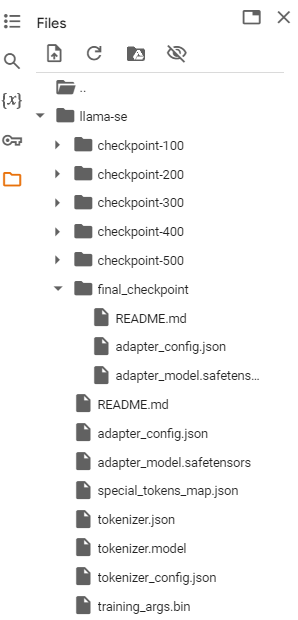

Note that it _only saves the adapter weights_, and not the full model! That `adapter_model.safetensors` file is only about 13MB.

## 7.2. Performance After Training

The same code as the "Performance Before Tuning" section, just make sure to now call `trainer.model`.

In [ ]:
# Earlier in the Notebook, we selected a specific example to look at and play
# with.
example = plucked_example

text = f"Question: {example['question']}\n\nAnswer: "

#Desired answer: {example['response_j']}

In [ ]:
device = "cuda:0"

# Tokenize the text, which returns it as a list of token ids.
input_ids = tokenizer(
    text,
    return_tensors = "pt" # Return them in a Pytorch Tensor.
)

# Move them to the GPU.
input_ids = input_ids.to(device)


In [ ]:
# Feed it in and generate output!
outputs = trainer.model.generate(**input_ids, max_new_tokens=512)

#input_ids[0].ids

In [ ]:
print(tokenizer.decode(outputs[0], skip_special_tokens=True))

## 7.3. Merge LoRA Weights

The mathematics of LoRA allow us to fold in the adapter layers.

**TODO** - Copy in the equation.

_However_, I suspect that the fact that the model does not fit into GPU memory without quantization means that this needs to be handled in some special way...

First, free up the GPU's memory!

**TODO** - Haven't figured this out yet--the original code just called `empty_cache`, but that didn't work for me.

In [83]:
import gc

# Free memory for merging weights
del model

torch.cuda.empty_cache()

gc.collect()


0

In [84]:
# Did it work?
check_gpu_mem()

,memory.total [MiB],memory.used [MiB]
1,15360 MiB,5741 MiB


Load the model again, this time using a different class with "Peft" in the name.

In [68]:
from peft import AutoPeftModelForCausalLM

# Load again
model = AutoPeftModelForCausalLM.from_pretrained(
    # Load from the 'final_checkpoint' directory.
    output_dir,

    device_map="auto",

    torch_dtype=torch.float16)



Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/accelerate/utils/modeling.py:1363: UserWarning: Current model requires 503324160 bytes of buffer for offloaded layers, which seems does not fit any GPU's remaining memory. If you are experiencing a OOM later, please consider using offload_buffers=True.
  warnings.warn(


Perform the merge step.

**TODO** - More on this.

In [69]:

model = model.merge_and_unload()


OutOfMemoryError: CUDA out of memory. Tried to allocate 112.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 91.06 MiB is free. Process 325788 has 14.66 GiB memory in use. Of the allocated memory 14.17 GiB is allocated by PyTorch, and 361.50 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

Save out the merged version.

In [ ]:
output_merged_dir = os.path.join(training_args.output_dir, "final_merged_checkpoint")

model.save_pretrained(output_merged_dir, safe_serialization=True)

**TODO** - Probably want some code here to save the checkpoint in a more permanent way, like copying to gdrive?

# ▂▂▂▂▂▂▂▂▂▂▂▂▂▂

# Appendix

## A.1. Comparing Performance


### i. Looking For Interesting Examples

**Plucked Example**

This code prints out the example at a specific index.

In [ ]:
import textwrap

# Wrap text to 80 characters.
wrapper = textwrap.TextWrapper(width=80)

# Loop through the training examples to reach our desired index.
for (i, example) in enumerate(dataset):

    if i == 3172:
        #if 'salt' in example['question']:
        print('▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂')
        print('\n======== Example {:,} ========\n'.format(i))
        print('\n======== Question ========\n')
        print(wrapper.fill(example['question']))

        print('\n======== Answer ========\n')
        print(wrapper.fill(example['response_j']))

        break


    if i > 20000:
        print('Went through 20000!')
        break

**Short Examples**



This code looks for a number of examples with fewer than (e.g., 256) tokens.

In [ ]:
import textwrap

# Wrap text to 80 characters.
wrapper = textwrap.TextWrapper(width=80)

found = 0

# Loop through the training examples to reach our desired index.
for (i, example) in enumerate(dataset):

    # Prepare a training sample by combining the question and answer with some
    # formatting.
    text = prepare_sample_text(example)

    # Tokenize and get the number of tokens.
    ex_num_tokens = len(tokenizer(text).tokens())

    if i < 155:
        continue

    if ex_num_tokens < 256 and 'python' in example['question']:

        print('▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂')
        print('\n======== Example {:,} ========\n'.format(i))
        print('qid:', example['qid'])
        print('\n======== Question ========\n')
        print(wrapper.fill(example['question']))

        print('\n======== Answer ========\n')
        print(wrapper.fill(example['response_j']))

        found = found + 1


    if found == 5:
        break







### ii. Raw Mistral 7B

TODO - This section will be to highlight some example generations prior to fine-tuning.

### iii. HuggingFace Final Model

You can try out their fully-trained model with the interface a little ways down in this blog post:

https://huggingface.co/blog/stackllama




StackLLaMa 1: https://huggingface.co/trl-lib/llama-7b-se-peft

* Sta-La-1 only has the adapter weights.

StackLLaMa 2: kashif/stack-llama-2

* Sta-La-2 has the entire model.


#### Load & Inspect

In [ ]:
# Check out memory useage prior to loading.
check_gpu_mem()

I copied the quantization configuration below from a huggingface tutorial Notebook [here](https://colab.research.google.com/drive/1ge2F1QSK8Q7h0hn3YKuBCOAS0bK8E0wf#scrollTo=HIxDplbNR_CY).

> "Let's load the model with NF4 quantization type for better results, `bfloat16` compute dtype as well as nested quantization for a more memory efficient model loading."

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('kashif/stack-llama-2', trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"  # Fix weird overflow issue with fp16 training


In [ ]:
import torch
from transformers import BitsAndBytesConfig

# This is what it was trained with...
bnb_config = BitsAndBytesConfig(
    load_in_4bit = True,
    #bnb_4bit_use_double_quant = True,
    bnb_4bit_quant_type = "nf4",

    #bnb_4bit_compute_dtype = torch.bfloat16

    # If T4:
    bnb_4bit_compute_dtype = torch.float16
)


In [ ]:
from transformers import AutoModelForCausalLM
#from transformers import MistralForCausalLM

t0 = time.time()

model = AutoModelForCausalLM.from_pretrained(

    #model = MistralForCausalLM.from_pretrained(

    # This is the completed model from the huggingface example.
    'kashif/stack-llama-2',

    quantization_config = bnb_config,

    #attn_implementation = "flash_attention_2", # You can't use this unless
    # you're running an A100 or newer.

    torch_dtype = torch.float16,

    # I was getting this output message:
    #    "`low_cpu_mem_usage` was None, now set to True since model is
    #      quantized."
    # If I tried setting it to False, then the Notebook crashed with:
    #    "Your session crashed after using all available RAM."
    low_cpu_mem_usage = True,

)

print("\nDownloading / loading model took", format_time(time.time() - t0))


I'm always curious what the actual class name is... 😊

In [ ]:
print(type(model))

In [ ]:
# And now memory usage after loading.
check_gpu_mem()

In [ ]:
model

#### Inference

They have a demo in the blog post with configurable generation settings:
https://huggingface.co/blog/stackllama



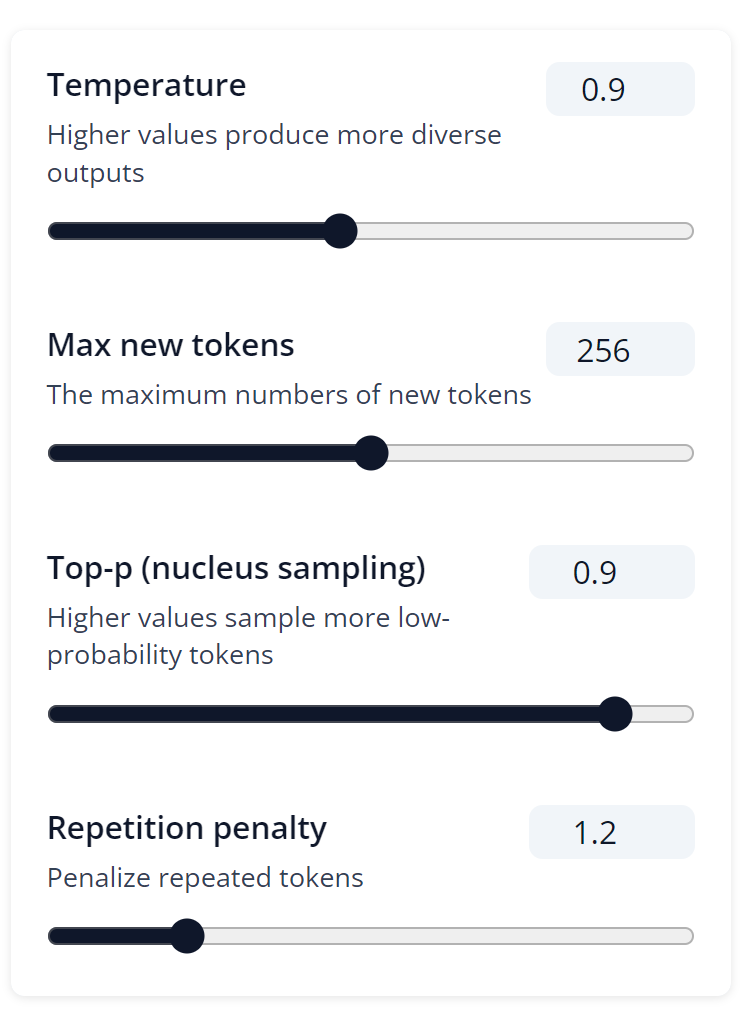

```
UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:415: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generat
```

In [ ]:
import random

# Define the number of examples to sample
num_samples = 4

# Specify the GPU as our device (need to move our inputs there).
device = "cuda:0"

# Iterate over the random indices and print the corresponding examples
s_i = 0

for example in dataset:

    s_i = s_i + 1

    if not s_i % 10 == 0:
        continue

    if s_i > 40:
        break

    print('\n\n==== Example {:,} ====\n\n'.format(s_i))

    # Format our prompt for the model.
    text = f"Question: {example['question']}\n\nAnswer: "


    # The desired answer is example['response_j']

    text = "I've heard that we haven't yet reconciled the theories of general relativity and quantum mechanics. Where do they disagree?"

    text = f"Question: {text}\n\nAnswer: "

    # Tokenize the text, which returns it as a list of token ids.
    input_ids = tokenizer(
        text,
        return_tensors = "pt" # Return them in a Pytorch Tensor.
    )

    # Move them to the GPU.
    input_ids = input_ids.to(device)

    # Feed it in and generate output!
    # top_p - the default for the model is 0.6, so I'm changing.
    #outputs = model.generate(**input_ids, max_new_tokens=512, top_p = 0.9, repetition_penalty = 1.2)

    t0 = time.time()

    outputs = model.generate(**input_ids,
                             max_length=512,

                             # The settings only are relevant if do_sample is true.
                             do_sample = True,
                             temperature = 0.9
                             top_p = 0.9,
                             repetition_penalty = 1.2)


    print('\n\n==== Output ====\n\n')

    # Print out the output!
    print(tokenizer.decode(outputs[0], skip_special_tokens=True))

    print("Generation took:", format_time(time.time() - t0))

    break



# ▂▂▂▂▂▂▂▂▂▂▂▂▂▂

# End